
# <p style="text-align: center;"> *PyData-Atlanta* </p>

<p style="text-align: center;"> Visualizing Equations Notebook </p>
---
 
 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

We used the reveal notebook extension for our slides and nb_conda to select environments. As of the date of the presentation, nb_conda wasn't working with the latest version of python, 3.6, hence we are using 3.5 here. Note, we are also using 12.4 instead of the latest version of bokeh. Here we used conda to make a suitable environment.

In [2]:
import sys
import platform
import bokeh
print("Python version", platform.python_version(), "and Bokeh version is", bokeh.__version__)
print("In which environment is Jupyter executing?", sys.executable)

Python version 3.5.2 and Bokeh version is 0.12.4
In which environment is Jupyter executing? C:\Users\jajaco3\AppData\Local\Continuum\Anaconda2\envs\py35\python.exe


In [3]:
def make_df(degree):
    rootbound = int(sum(x * (2 ** (x -1)) for x in range(degree+1)))
    roots = np.zeros((rootbound,2))
    index = 0
    for j in range(degree):
        rootsj = np.load('zerosEqual' + str(j + 1) + '.npy')
        for z in rootsj:
            roots[index] = z
            index = index + 1
    df = pd.DataFrame(roots, columns = ['real', 'imaginary'])
    return df

In [4]:
%time df4 = make_df(4)

Wall time: 9.03 ms


In [15]:
%time df13 = make_df(13)

Wall time: 120 ms


In [17]:
%time df16 = make_df(16)

Wall time: 780 ms


In [5]:
%time df23 = make_df(23)

Wall time: 2min 28s


The dataframe df23 holds all the roots of 0,1 polynomials of degree 23 or less. There are 184549377 such roots, excluding zero.

In [6]:
len(df23)

184549377

In [7]:
%time df25 = make_df(25)

Wall time: 18min 1s


The dataframe df25 holds all the roots of 0,1 polynomials of degree 25 or less. There are 805306369 such roots, excluding zero.

In [8]:
len(df25)

805306369

## For mapping a small number of roots, the default parameters look very good. For example:

In [19]:
plt.xkcd()
plt.scatter(df4.real, df4.imaginary)
plt.ylabel('Imaginary')
plt.xlabel('Real')
plt.axis([-1.5,1.5,-1.5,1.5])
plt.title('zeros of 0,1 polynomials of degrees <= 4')

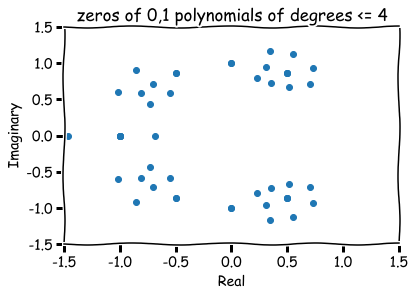

In [20]:
plt.show()

Note how long it takes to display the next image.

In [21]:
plt.xkcd()
plt.scatter(df16.real, df16.imaginary)
plt.ylabel('Imaginary')
plt.xlabel('Real')
plt.axis([-1.5,1.5,-1.5,1.5])
plt.title('zeros of 0,1 polynomials of degrees <= 16')

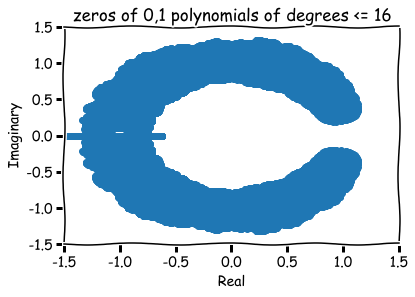

Wall time: 6.74 s


In [22]:
%time plt.show()

In [23]:
len(df16)

983041

So, there are close to a million roots that we are trying to display. Lots of overplotting in the figure above. Next, we adjust the parameters to recreate the figure from the paper.

To get an 'xkcd' version of the original:
- increase the figure size
- change the marker to a point
- decrease the marker size
- color it black



In [29]:
plt.figure(figsize=(10,10))
plt.ylabel('y')
plt.xlabel('x')
plt.title('zeros of 0,1 polynomials of degrees <= 16')
plt.axis([-1.5,1.5,-1.5,1.5])
plt.scatter(df16.real, df16.imaginary, c = "black", s=0.010, marker = ".")

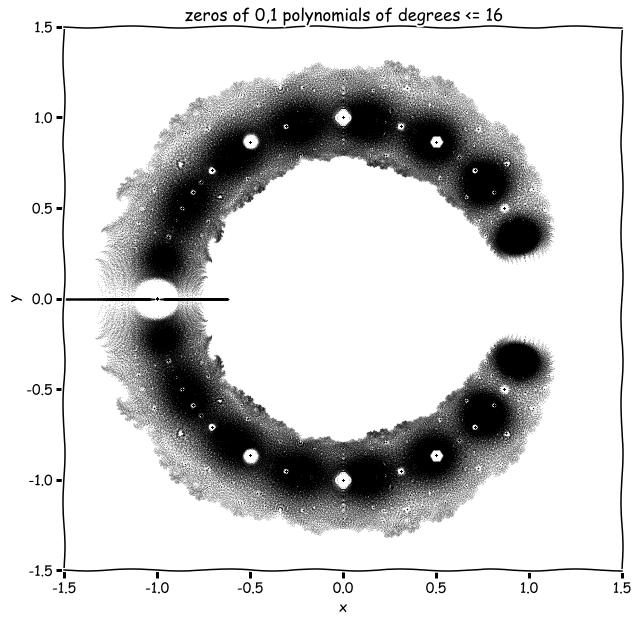

Wall time: 3.32 s


In [30]:
%time plt.show()

## Bokeh

Bokeh has an interactive zoom feature.

In [31]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, reset_output, show
output_notebook()

Loading BokehJS ...

We now consider roots of 0,1 polynomials of degree less than or equal to 13.

In [33]:
to_plot = figure(title = 'zeros of 0,1 polynomials of degrees <= 13')
to_plot.circle(df13.real, df13.imaginary, color = "black",size = 0.1)

GlyphRenderer(id='35dcfdc7-84c4-42c6-a2c1-d2f9e0bc85da', ...)

Visualize the precision of the solutions by, for instance, zooming in on the real root $z=-1$.

In [34]:
show(to_plot) 

## Datashader bokeh extension

Datashader takes as input pandas dataframes. With the Bokeh extension of datashader called **InteractiveImage** it is possible to easily work interactively with hundreds of millions of points, and to visualize on the order of a billion points.

In [35]:
import datashader as ds
import datashader.transfer_functions as tf

In [36]:
%%time
cvs = ds.Canvas(plot_width = 600, plot_height = 600, x_range=(-1.5,1.5), y_range=(-1.5,1.5))
agg = cvs.points(df25, 'real', 'imaginary')

Wall time: 2min 12s


Wall time: 232 ms


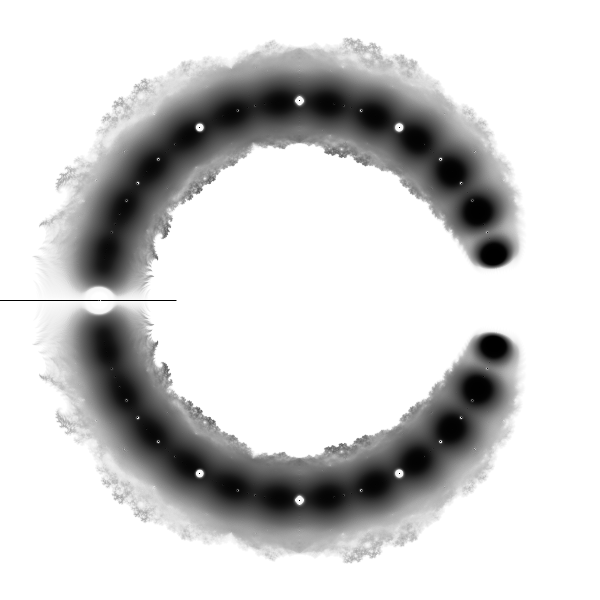

In [37]:
%time tf.shade(agg, cmap=["white", "black"])

In the paper, the authors mentioned that by plotting roots of randomly chosen 0,1 polynomials, it became clear that the fractal-like parts of the figure were due to very few polynomials. Below we show only the points where exactly one root is found.

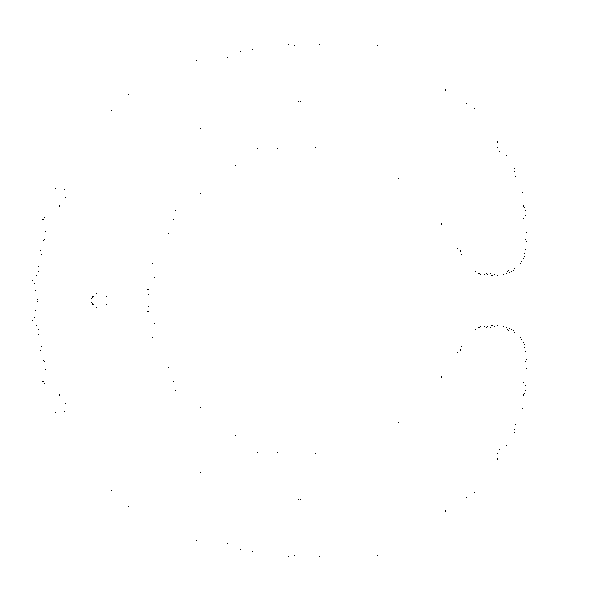

In [38]:
tf.shade(agg.where(agg <= 1), cmap=["white", "black"])

Next, only the points where more than 100000 are found.

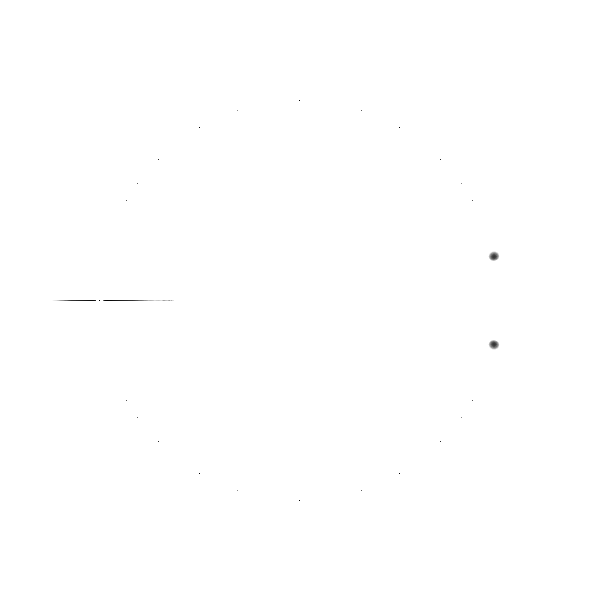

In [41]:
tf.shade(agg.where(agg > 100000), cmap=["white", "black"])

In [42]:
from datashader.colors import inferno, viridis
import colorcet as cc

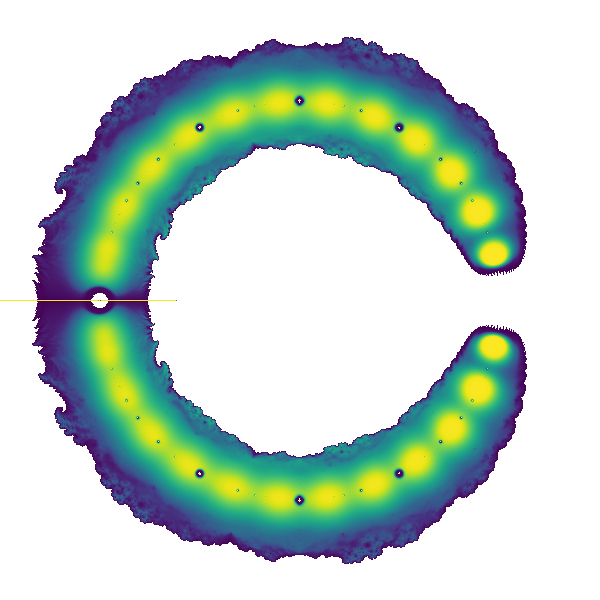

In [43]:
tf.shade(agg, cmap=viridis)

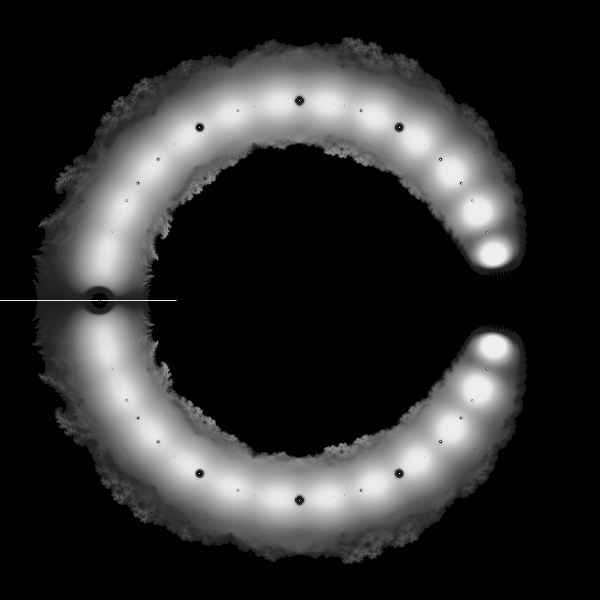

In [44]:
tf.set_background(tf.shade(agg, cmap=cc.dimgray), "black")

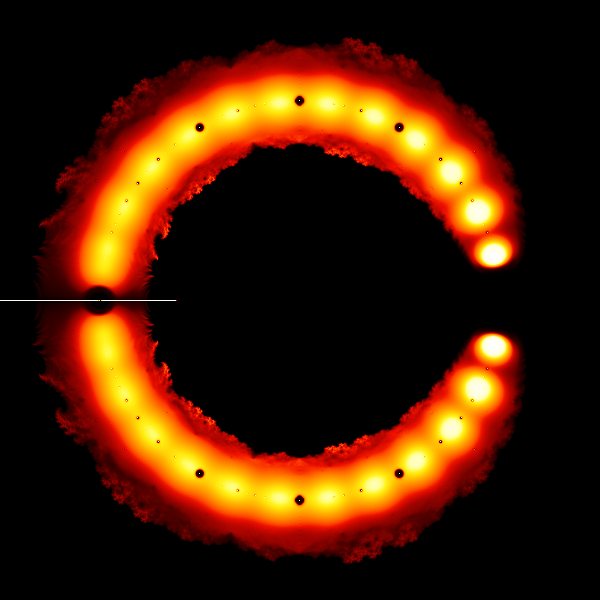

In [45]:
tf.set_background(tf.shade(agg, cmap=cc.fire), "black")

# Datashader interactive zoom

In [47]:
import bokeh.plotting as bp
from datashader.bokeh_ext import InteractiveImage

What did I mean by "fractal-like"? Zoom on the wave-like curve on the left to see the scale-free properties of this part of the image. 

In [48]:
%%time 
new_plot = bp.figure(tools='pan,wheel_zoom,box_zoom,reset', x_range=(-1.5,1.5), y_range=(-1.5,1.5))

def image_callback(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width = 600, plot_height = 600, x_range=x_range, y_range=y_range)
    agg = cvs.points(df23, 'real', 'imaginary', ds.any())
    img =tf.set_background(tf.shade(agg, cmap=cc.fire), "black")
    return tf.dynspread(img, max_px = 100) 

Wall time: 12 ms


In [49]:
InteractiveImage(new_plot, image_callback)

In [50]:
%%time

new_plot = bp.figure(tools='pan,wheel_zoom,box_zoom,reset', x_range=(-1.5,1.5), y_range=(-1.5,1.5))

def image_callback(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width = 600, plot_height = 600, x_range=x_range, y_range=y_range)
    agg = cvs.points(df23, 'real', 'imaginary')
    img =tf.set_background(tf.shade(agg, cmap=list(reversed(cc.fire))), "black")
    return tf.spread(img)

Wall time: 7 ms


Don't forget to zoom on z=-1 to see the cross within a star within a diamond within a point. Up to degree 23 is as high as possible. Degree 24 has wait times after zooming of a minute.

In [51]:
%time InteractiveImage(new_plot, image_callback)

Wall time: 5.79 s


Zoom on imaginary number...note the patterns around it.
Past ten decimal places it is clear the error in root finding. Would be interesting to compare the numpy roots with the roots found using the algorithm in the paper. For instance, write an extension module that interfaces to the fortran subroutine used in the paper. 

Thank you!